training X  (6, 200, 1)
training Y  (6, 200, 1)
CNMP(
  (encoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=129, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)
iteration  0


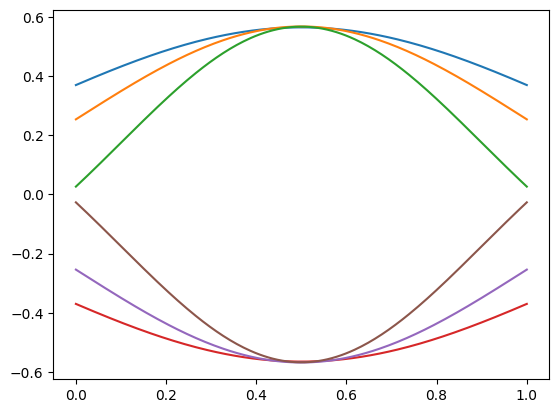

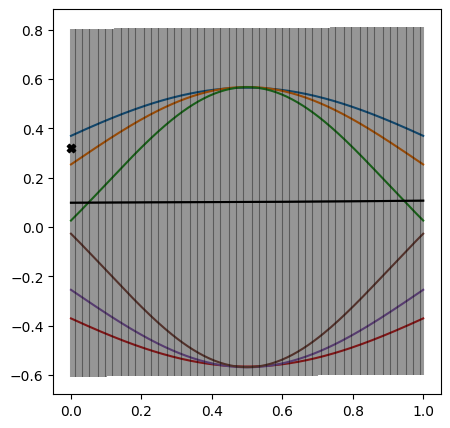

iteration  10000


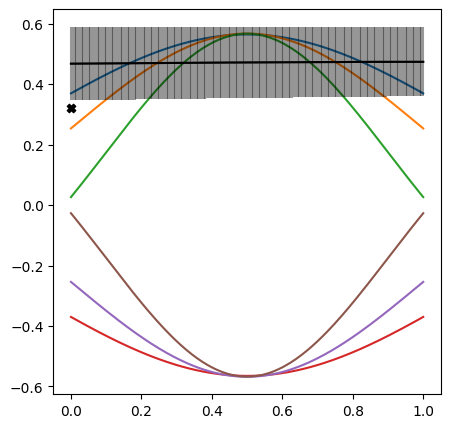

iteration  20000


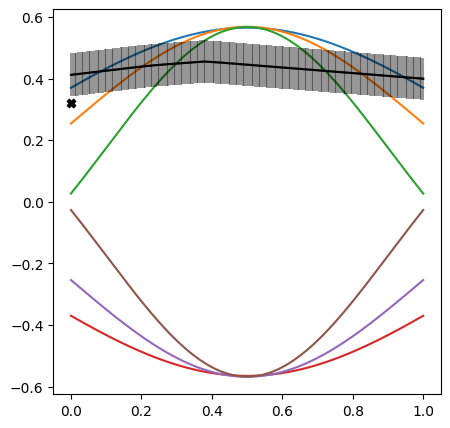

iteration  30000


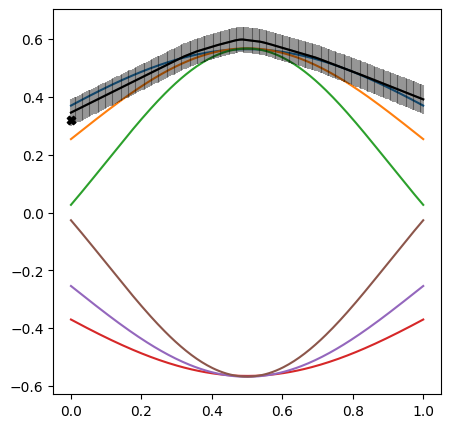

iteration  40000


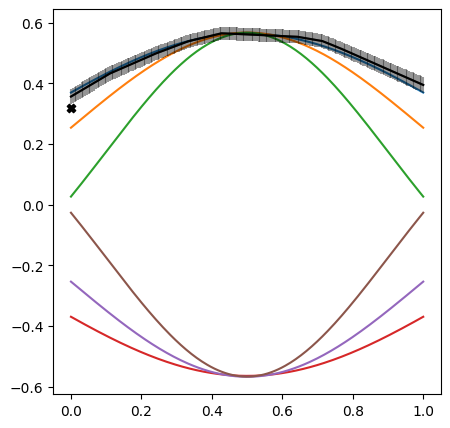

iteration  50000


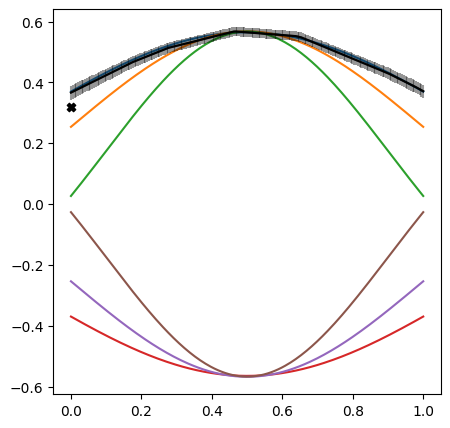

iteration  60000


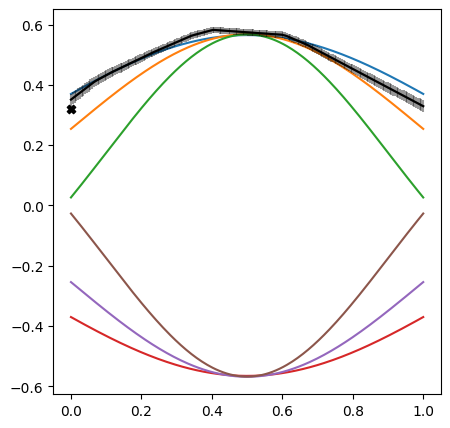

iteration  70000


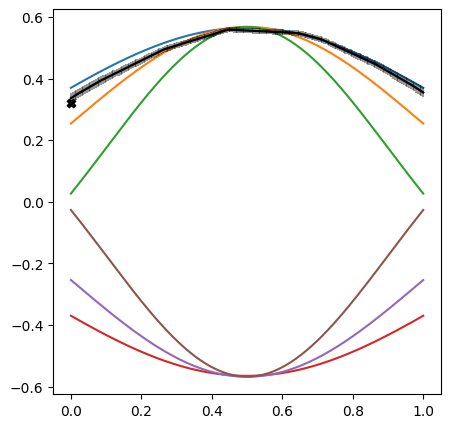

iteration  80000


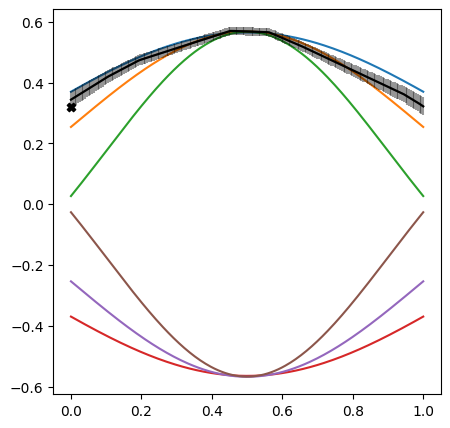

iteration  90000


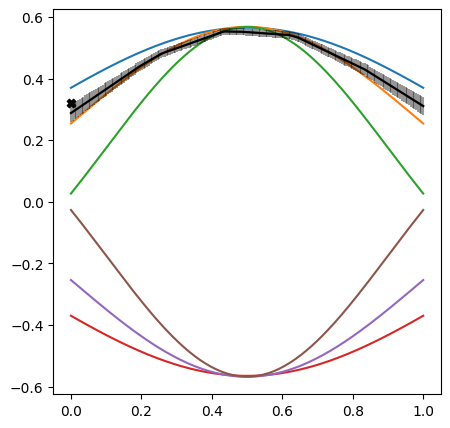

/var/folders/63/kw9gvntx3hzftcn6fp7wkf0c0000gn/T/ipykernel_7091/293913599.py:140: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.

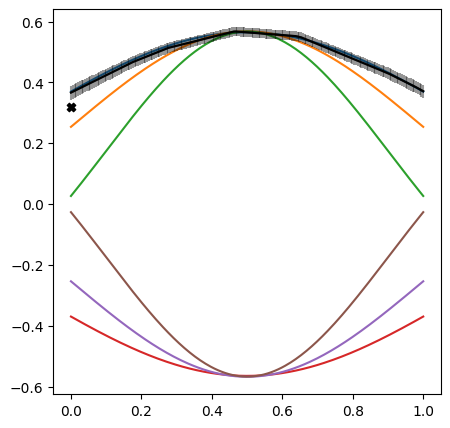

(array([[0.36647823],
        [0.36935864],
        [0.37223905],
        [0.37511946],
        [0.37799987],
        [0.38087967],
        [0.38375876],
        [0.38663784],
        [0.38951693],
        [0.39239601],
        [0.39527509],
        [0.39815418],
        [0.40103326],
        [0.40391235],
        [0.40679143],
        [0.40967052],
        [0.4125496 ],
        [0.41542868],
        [0.41830777],
        [0.42118685],
        [0.42406594],
        [0.42694502],
        [0.42982411],
        [0.43270319],
        [0.43558227],
        [0.43846136],
        [0.44134044],
        [0.44421953],
        [0.44709861],
        [0.4499777 ],
        [0.45285678],
        [0.45573586],
        [0.45861495],
        [0.46149403],
        [0.46437312],
        [0.46710639],
        [0.46944918],
        [0.47179197],
        [0.47413476],
        [0.47647755],
        [0.47882034],
        [0.48116313],
        [0.48350593],
        [0.48584872],
        [0.48819151],
        [0

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import math

time_len = 200

def generate_demonstrations(time_len = 200, params = None, title = None):
    def dist_generator(d, x, param, noise = 0):
        f = (math.exp(-x**2/(2.*param[0]**2))/(math.sqrt(2*math.pi)*param[0]))+param[1]
        return f+(noise*(np.random.rand()-0.5)/100.)
    #fig = plt.figure(figsize=(5,5))
    x = np.linspace(-0.5,0.5,time_len)
    times = np.zeros((params.shape[0],time_len,1))
    times[:] = x.reshape((1,time_len,1))+0.5
    values = np.zeros((params.shape[0],time_len,1))
    for d in range(params.shape[0]):
            for i in range(time_len):
                values[d,i] = dist_generator(d,x[i],params[d])
            plt.plot(times[d], values[d])
    #plt.title(title+' Demonstrations')
    #plt.ylabel('Y')
    #plt.xlabel('time (t)')
    #plt.show()
    return times, values

# gets random number of random obs. points from a random trajectory. Also gets a 
# random target (x,y) from the same trajectory
def get_training_sample():
    
    n = np.random.randint(0,OBS_MAX)+1
    d = np.random.randint(0, d_N)
    
    observations = np.zeros((n,d_x+d_y)) 
    target_X = np.zeros((1,d_x))
    target_Y = np.zeros((1,d_y))
    
    perm = np.random.permutation(time_len)
    observations[:,:d_x] = X[d,perm[:n]]
    observations[:,d_x:d_x+d_y] = Y[d,perm[:n]]
    target_X[0] = X[d,perm[n]]
    target_Y[0] = Y[d,perm[n]]
    return torch.from_numpy(observations), torch.from_numpy(target_X), torch.from_numpy(target_Y)

def log_prob_loss(output, y_target): 
    mean, std = output.chunk(2, dim=-1)
    std = F.softplus(std)
    dist = D.Independent(D.Normal(loc=mean, scale=std), 1)  # (d_y distributions)
    return -torch.mean(dist.log_prob(y_target)) 

def predict_model(observations, target_X, plot = True):
    d_N = X.shape[0]
    predicted_Y = np.zeros((time_len,d_y))
    predicted_std = np.zeros((time_len,d_y))
    with torch.no_grad():
        prediction = model(torch.from_numpy(observations),torch.from_numpy(target_X)).numpy()
    predicted_Y = prediction[:,:d_y]
    predicted_std = np.log(1+np.exp(prediction[:,d_y:]))
    if plot: # We highly recommend that you customize your own plot function, but you can use this function as default
        for i in range(d_y): #for every feature in Y vector we are plotting training data and its prediction
            fig = plt.figure(figsize=(5,5))
            for j in range(d_N):
                plt.plot(X[j,:,0],Y[j,:,i]) # assuming X[j,:,0] is time
            plt.plot(X[j,:,0],predicted_Y[:,i],color='black')
            plt.errorbar(X[j,:,0],predicted_Y[:,i],yerr=predicted_std[:,i],color = 'black',alpha=0.4)
            plt.scatter(observations[:,0],observations[:,d_x+i],marker="X",color='black')
            plt.show()  
    return predicted_Y, predicted_std

class CNMP(nn.Module):
    def __init__(self, d_x, d_y):
        super(CNMP, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(d_x + d_y, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, 128)
        )

        self.decoder = nn.Sequential(
            nn.Linear(d_x + 128, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, 2*d_y)
        )
    def forward(self, obs, x_tar): # obs is (n, d_x + d_y)

        r = self.encoder(obs) # (n,128)
        r_avg = torch.mean(r, 0) # (1,128)
        r_avg = r_avg.repeat(x_tar.shape[0],1) # Duplicating general representation for every target_t

        concat = torch.cat((r_avg, x_tar), dim=-1)
        output = self.decoder(concat) # (2*d_y,)
        return output

############################################################################################################

X, Y = generate_demonstrations(time_len=200, params=np.array([[0.6,-0.1],[0.5,-0.23],[0.4,-0.43],[-0.6,0.1],[-0.5,0.23],[-0.4,0.43]]), title='Training')
print('training X ', X.shape)
print('training Y ',Y.shape)

OBS_MAX = 5
d_x = X.shape[-1]
d_y = Y.shape[-1]
d_N = X.shape[0]

model = CNMP(d_x, d_y).double()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
print(model.eval())

errors = []

for i in range(100000):
    obs, x_tar, y_tar = get_training_sample()

    optimizer.zero_grad()

    output = model(obs, x_tar)
    loss = log_prob_loss(output, y_tar)
    
    loss.backward()
    optimizer.step()

    if i % 1000 == 0:
        predicted_Y, predicted_std = torch.zeros((time_len,d_y)), torch.zeros((time_len,d_y))
        if i % 10000 == 0:
            print('iteration ', i)
            predicted_Y,predicted_std = predict_model((np.concat((X[0,:1],[[0.32]]), axis=-1)),X[0],plot=True)
        else:
            predicted_Y,predicted_std = predict_model((np.concat((X[0,:1],[[0.32]]), axis=-1)),X[0],plot=False)
        error = np.mean((predicted_Y - Y[0])**2)
        errors.append(error)
        if error == min(errors):
            torch.save(model.state_dict(), 'best_model.pth')


model.load_state_dict(torch.load('best_model.pth'))
predict_model((np.concat((X[0,:1],[[0.32]]), axis=-1)),X[0])


# Testing
